# Результаты исследования

Интересы пользователей зависят от того, прошла церемония или нет.
 
- До церемонии людям было интересно кто номинируется на премию.

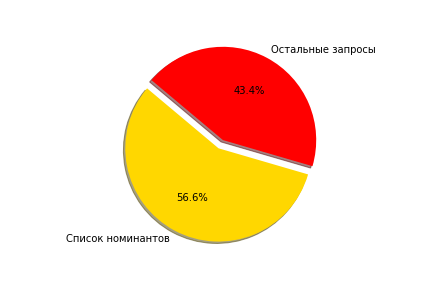

- Во время церемонии люди искали ссылки на трансляцию и время начала награждения

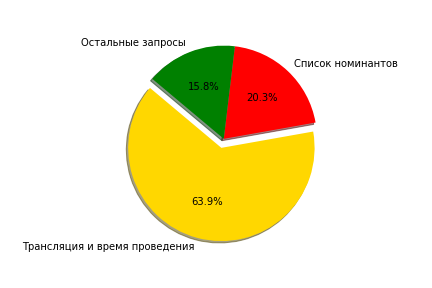

- После награждения, пользователей интересовали результаты церемонии

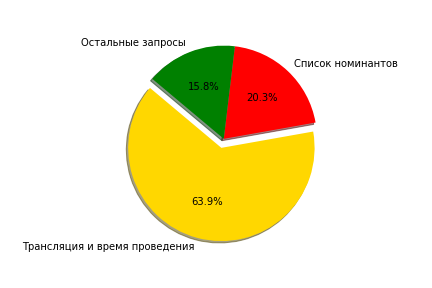

В зависимости от интента понятно, что колдунщик должен выглядеть по-разному в разное время и для разных интентов.

До цеременонии вручения для запросов, содержащих слово Оскар или Оскар в связке с (Номинант, Список, Кто, Фильм) колдунщик должен отображать Номинантов и ссылки на них в Кинопоиске. 

Во время церемонии, если запрос содержит слова Оскар, Оскар в связке с (Трансляция, Смотреть, Когда, Номинант, Список и т.д):
- До начала церемонии будем выводить список номинантов и время ее проведения
- Ближе к началу, будем отображать окно с трансляцией

После церемонии, если интент запроса тема Оскара, будем отображать результаты вручения в каждой номинации и ссылки на них в Кинопоиск.


## План исследования

1. Выделить запросы, которые содержат слово "Оскар"
1. Разделить эти запросы на до и после церемонии Оскар (24.02.2019)
1. Привести все слова в начальную форму
1. Создать на основе запросов биграммы и триграммы, и посмотреть их статистику встечаемости среди запросов, содержащих слово **Оскар**
2. Посмотреть на основные интенты
3. Придумывать как по запросу понять, какой колдунщик нужен

In [1]:
# Это нужно для того, чтобы скрывать код

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Посмотреть код'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [2]:
import pandas as pd
from collections import Counter
import scipy
from scipy import spatial
import datetime
import warnings
warnings.filterwarnings('ignore')

#!pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

df = pd.read_csv('oscar', sep='\t')
oscar = df[df['normal_query'].str.contains('оскар')==True]
oscar['datetime'] = pd.to_datetime(oscar['datetime'])
hide_toggle()

### Функции для предобработки запросов

In [3]:
def split_query(query):
    split_list = []
    for word in query.split():
        if len(word) > 2:
            split_list.append(word)
    return split_list

def normalize_query(query):
    normalized_query = []
    for word in split_query(query):
        normalized_query.append(morph.parse(word)[0].normal_form)
    return normalized_query

#oscar['splitted'] = oscar['normal_query'].apply(lambda x: split_query(x))
oscar['normalized_query'] = oscar['normal_query'].apply(lambda x: normalize_query(x))

def popular_words(query, n):
    popular_words = []
    for row in query:
        for word in row:
            popular_words.append(word)
    return Counter(popular_words).most_common(n)

def top_bigrams(query, n):
    all_bigrams = []
    bigrams = []
    for sentence in query:
        all_bigrams.append([sentence[i:i+2] for i in range(len(sentence)-2+1)])
    for ngram in all_bigrams:
        for bigram in ngram:
            bigrams.append(bigram[0] + ' ' + bigram[1])
    return Counter(bigrams).most_common(n)

def top_trigrams(query, n):
    all_bigrams = []
    bigrams = []
    for sentence in query:
        all_bigrams.append([sentence[i:i+3] for i in range(len(sentence)-3+1)])
    for ngram in all_bigrams:
        for bigram in ngram:
            bigrams.append(bigram[0] + ' ' + bigram[1] + ' ' + bigram[2])
    return Counter(bigrams).most_common(n)

hide_toggle()

### Посмотрим какие запросы делают до  церемонии

In [4]:
before_oscar = oscar[(oscar['datetime'] <='2019-02-23')]
before_oscar.head()

,normal_query,datetime,normalized_query
10663,пряности и страсти оскар,2019-01-27 20:43:54,"[пряность, страсть, оскар]"
12710,оскар лауреаты по годам,2019-01-29 12:26:55,"[оскар, лауреат, год]"
31613,счастливый принц оскар уайльд читать,2019-01-28 10:46:45,"[счастливый, принц, оскар, уайльд, читать]"
35816,ленардо дикаприо получил серебряного оскара из...,2019-02-01 14:24:41,"[ленардо, дикаприо, получить, серебряный, оска..."
45970,русский получил порно оскар,2019-01-31 17:47:15,"[русский, получить, порно, оскар]"


In [5]:
popular_words(before_oscar['normalized_query'], 20)

[('оскар', 2967),
 ('2019', 716),
 ('фильм', 520),
 ('номинант', 337),
 ('получить', 166),
 ('хороший', 163),
 ('премия', 157),
 ('2018', 150),
 ('уайльд', 132),
 ('порно', 120),
 ('список', 104),
 ('год', 82),
 ('номинация', 70),
 ('когда', 64),
 ('победитель', 57),
 ('вручение', 56),
 ('смотреть', 51),
 ('кучер', 50),
 ('какой', 48),
 ('2017', 48)]

#### Биграммы до Оскара

In [6]:
top_bigrams(before_oscar['normalized_query'], 20)

[('оскар 2019', 694),
 ('номинант оскар', 197),
 ('премия оскар', 144),
 ('оскар уайльд', 130),
 ('получить оскар', 129),
 ('оскар 2018', 124),
 ('порно оскар', 108),
 ('фильм оскар', 104),
 ('2019 номинант', 87),
 ('хороший фильм', 82),
 ('оскар хороший', 73),
 ('2019 список', 52),
 ('номинация оскар', 50),
 ('фильм получить', 49),
 ('оскар кучер', 49),
 ('номинировать оскар', 46),
 ('фильм номинировать', 37),
 ('оскар 2017', 36),
 ('вручение оскар', 35),
 ('оскар бентон', 34)]

#### Триграммы до Оскара

In [7]:
top_trigrams(before_oscar['normalized_query'], 20)

[('номинант оскар 2019', 147),
 ('оскар 2019 номинант', 87),
 ('оскар 2019 список', 52),
 ('премия оскар 2019', 51),
 ('фильм получить оскар', 46),
 ('оскар хороший фильм', 43),
 ('фильм номинировать оскар', 37),
 ('фильм оскар 2018', 23),
 ('оскар 2019 когда', 22),
 ('оскар розовый дама', 22),
 ('номинант премия оскар', 22),
 ('фильм номинант оскар', 19),
 ('получить оскар ivi', 18),
 ('вручение премия оскар', 18),
 ('номинация оскар 2019', 17),
 ('порно оскар 2019', 17),
 ('фильм незаслуженно получить', 16),
 ('незаслуженно получить оскар', 16),
 ('между я ты', 16),
 ('фильм оскар 2019', 16)]

### Во время оскара

In [8]:
oscar_time = oscar[(oscar['datetime'] > '2019-02-24') & (oscar['datetime'] < '2019-02-25')]
oscar_time.head()

,normal_query,datetime,normalized_query
187181,церемония оскар,2019-02-24 20:38:34,"[церемония, оскар]"
198682,номинации на оскар 2019,2019-02-24 20:40:18,"[номинация, оскар, 2019]"
1806997,фильмы оскар 2018 список победители,2019-02-24 19:23:04,"[фильм, оскар, 2018, список, победитель]"
1810759,оскар,2019-02-24 19:23:28,[оскар]
1841110,номинанты на оскар 2019,2019-02-24 19:28:11,"[номинант, оскар, 2019]"


In [9]:
popular_words(oscar_time['normalized_query'], 20)

[('оскар', 320),
 ('2019', 194),
 ('трансляция', 36),
 ('когда', 27),
 ('премия', 24),
 ('фильм', 23),
 ('номинант', 23),
 ('быть', 18),
 ('церемония', 13),
 ('уайльд', 11),
 ('хороший', 10),
 ('вручение', 9),
 ('список', 8),
 ('русский', 8),
 ('сколько', 8),
 ('получить', 8),
 ('2018', 7),
 ('прямая', 6),
 ('где', 6),
 ('смотреть', 5)]

#### Биграммы во время Оскара

In [10]:
top_bigrams(oscar_time['normalized_query'], 20)

[('оскар 2019', 187),
 ('премия оскар', 24),
 ('2019 когда', 21),
 ('когда быть', 17),
 ('быть трансляция', 13),
 ('номинант оскар', 11),
 ('оскар уайльд', 11),
 ('2019 номинант', 9),
 ('2019 трансляция', 9),
 ('церемония оскар', 8),
 ('оскар 2018', 7),
 ('вручение оскар', 7),
 ('прямая трансляция', 6),
 ('трансляция оскар', 6),
 ('оскар хороший', 6),
 ('получить оскар', 6),
 ('хороший фильм', 5),
 ('2019 список', 4),
 ('список фильм', 4),
 ('фильм оскар', 3)]

#### Триграммы во время Оскара

In [11]:
top_trigrams(oscar_time['normalized_query'], 20)

[('оскар 2019 когда', 21),
 ('2019 когда быть', 17),
 ('когда быть трансляция', 13),
 ('премия оскар 2019', 12),
 ('оскар 2019 номинант', 9),
 ('оскар 2019 трансляция', 9),
 ('номинант оскар 2019', 8),
 ('трансляция оскар 2019', 6),
 ('церемония оскар 2019', 5),
 ('оскар 2019 список', 4),
 ('вручение оскар 2019', 4),
 ('оскар 2018 список', 3),
 ('оскар 2019 прямая', 3),
 ('2019 прямая трансляция', 3),
 ('2019 список фильм', 3),
 ('оскар 2019 смотреть', 3),
 ('оскар хороший фильм', 3),
 ('2019 трансляция россия', 3),
 ('оскар 2019 время', 2),
 ('оскар уайльд читать', 2)]

### После оскара

In [12]:
oscar_after = oscar[(oscar['datetime'] > '2019-02-25')]
oscar_after.head()

,normal_query,datetime,normalized_query
14560,зеленая книга номинации на оскар 2019,2019-02-26 17:10:05,"[зелёный, книга, номинация, оскар, 2019]"
17630,призер оскара 2019,2019-02-26 17:10:40,"[призёр, оскар, 2019]"
18821,оскар 2019 победители,2019-02-26 17:11:00,"[оскар, 2019, победитель]"
18846,призер оскара 2019 в платье,2019-02-26 17:11:01,"[призёр, оскар, 2019, платье]"
51962,оскар 2018,2019-02-25 15:00:57,"[оскар, 2018]"


In [13]:
popular_words(oscar_after['normalized_query'], 20)

[('оскар', 3314),
 ('2019', 2191),
 ('фильм', 251),
 ('премия', 228),
 ('победитель', 189),
 ('смотреть', 182),
 ('получить', 157),
 ('трансляция', 149),
 ('хороший', 129),
 ('кто', 128),
 ('церемония', 118),
 ('гага', 114),
 ('вручение', 112),
 ('номинант', 106),
 ('леди', 97),
 ('результат', 87),
 ('дорожка', 87),
 ('рами', 79),
 ('малёк', 79),
 ('2018', 78)]

#### Биграммы после Оскара

In [14]:
top_bigrams(oscar_after['normalized_query'], 20)

[('оскар 2019', 2121),
 ('премия оскар', 218),
 ('2019 смотреть', 124),
 ('получить оскар', 100),
 ('леди гага', 97),
 ('вручение оскар', 79),
 ('кто получить', 78),
 ('рами малёк', 70),
 ('2019 победитель', 68),
 ('победитель оскар', 68),
 ('красный дорожка', 65),
 ('церемония оскар', 63),
 ('оскар 2018', 62),
 ('хороший фильм', 58),
 ('гага оскар', 56),
 ('2019 кто', 50),
 ('фильм оскар', 50),
 ('2019 номинант', 48),
 ('прямая трансляция', 48),
 ('оскар хороший', 47)]

#### Триграммы после Оскара

In [15]:
top_trigrams(oscar_after['normalized_query'], 20)

[('премия оскар 2019', 138),
 ('оскар 2019 смотреть', 124),
 ('оскар 2019 победитель', 68),
 ('вручение оскар 2019', 53),
 ('победитель оскар 2019', 53),
 ('леди гага оскар', 51),
 ('оскар 2019 кто', 50),
 ('оскар 2019 номинант', 48),
 ('церемония оскар 2019', 44),
 ('оскар 2019 прямая', 43),
 ('2019 кто получить', 43),
 ('оскар 2019 результат', 42),
 ('оскар 2019 трансляция', 41),
 ('оскар 2019 фото', 38),
 ('получить оскар 2019', 37),
 ('2019 прямая трансляция', 36),
 ('оскар 2019 красный', 36),
 ('2019 красный дорожка', 36),
 ('оскар 2019 наряд', 36),
 ('кто получить оскар', 34)]

In [16]:
import matplotlib.pyplot as plt

sum_1 = 0
sum_2 = 0
for tup in top_trigrams(before_oscar['normalized_query'], 20):
    sum_2 = sum_2 + tup[1]
    if 'номинант' in tup[0] or 'список' in tup[0] or 'номинация' in tup[0] or 'номинировать' in tup[0] or 'кто' in tup[0] or 'вручение' in tup[0]:
        sum_1 = sum_1 + tup[1]
#print(sum_1, sum_2, sum_1/sum_2)
hide_toggle()




In [17]:
sum_1 = 0
sum_2 = 0
sum_3 = 0
for tup in top_trigrams(oscar_time['normalized_query'], 20):
    sum_2 = sum_2 + tup[1]
    if 'когда' in tup[0] or 'трансляция' in tup[0] or 'церемония' in tup[0] or 'смотреть' in tup[0] or 'прямая' in tup[0] or 'время' in tup[0]:
        sum_1 = sum_1 + tup[1]
for tup in top_trigrams(oscar_time['normalized_query'], 20):
    if 'номинант' in tup[0] or 'список' in tup[0] or 'номинация' in tup[0] or 'номинировать' in tup[0] or 'кто' in tup[0]:
        sum_3 = sum_3 + tup[1]        
#print(sum_1, sum_2, sum_3, sum_1/sum_2, sum_3/sum_2)
hide_toggle()

In [18]:
sum_1 = 0
sum_2 = 0
for tup in top_trigrams(oscar_after['normalized_query'], 20):
    sum_2 = sum_2 + tup[1]
    if 'результат' in tup[0] or 'победитель' in tup[0] or 'получить' in tup[0] or 'кто' in tup[0] or 'премия' in tup[0] or 'вручение' in tup[0] or 'смотреть'in tup[0] or 'фото' in tup[0]:
        sum_1 = sum_1 + tup[1]      
#print(sum_1, sum_2, sum_3, sum_1/sum_2)
hide_toggle()
